



#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 두가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 3단계 : 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇 2개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 설치

In [3]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
!pip install gensim

#### 2) 형태소 분석을 위한 라이브러리

In [4]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.15).
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
g++ set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
B

In [5]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 36.0 MB/s eta 0:00:00
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  2256k      0 --:--:-- --:--:-- --:--:-- 9212k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1
mecab-0.996-ko-0.9.2/man/Makefile.in
mecab-0.996-ko-0.9.2/mecab.iss.in
mecab-0.996-ko-0.9.2/confi

### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import *

from sklearn.metrics.pairwise import cosine_similarity

* 형태소 분석을 위한 함수를 제공합니다.

In [7]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [8]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions
* Google Colab 환경에서 진행을 권장합니다.
    * 구글 드라이브 바로 밑에 project 폴더를 만들고,
    * 데이터 파일을 복사해 넣습니다.

#### 1) Google Colab 환경 구축

* 구글 드라이브 연결

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
path = '/content/drive/MyDrive/ddk/'

#### 2) 저장된 데이터 읽어오기
* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [11]:
train = joblib.load(path + 'train_data.pkl')
test = joblib.load(path + 'test_data.pkl')
clean_train = joblib.load(path + 'clean_train.pkl')
clean_test = joblib.load(path + 'clean_test.pkl')

In [12]:
train.head()

,intent,Q,A,type,len_Q
0,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0,16
1,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0,12
2,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0,13
3,1,노트북 전원이 안들어와,AS센터에 맡겨보세요.,0,13
4,1,노트북을 떨어뜨려서 고장 난 것 같아,AS센터에 맡겨보세요.,0,21


### (3) 챗봇 구축

# 챗봇1


* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [13]:
mecab_lt = list(train['Q'].map(lambda x : tokenize('mecab', x).split()).values)

#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원),
    * window(컨텍스트 창의 크기),
    * max_vocab_size(고려할 최대 어휘 크기),
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [14]:
from gensim.models import Word2Vec

wv_model = Word2Vec(mecab_lt,
                    vector_size=100,
                    window=5,
                    min_count=1,
                    sg=1)

In [15]:
vector = wv_model.wv['핸드폰']
sims = wv_model.wv.most_similar('핸드폰', topn=10)
sims

[('후', 0.9984378814697266),
 ('한테', 0.9981805086135864),
 ('않', 0.9981607794761658),
 ('안', 0.9981487989425659),
 ('에서', 0.9981377124786377),
 ('게', 0.998094379901886),
 ('시험', 0.9980919361114502),
 ('점', 0.9980477094650269),
 ('해서', 0.9980065226554871),
 ('중점', 0.9980030655860901)]

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [16]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수
def get_sent_embedding(model, embedding_size, tokenized_words):
    feature_vec = np.zeros((embedding_size,), dtype='float32')  # 임베딩 벡터를 0으로 초기화
    n_words = 0  # 단어 개수 초기화
    index_to_key_set = set(model.wv.index_to_key)  # 모델 단어 집합 생성

    for word in tokenized_words:  # 문장의 단어들을 하나씩 반복
        if word in index_to_key_set:  # 모델 단어 집합에 해당하는 단어일 경우에만
            n_words += 1  # 단어 개수 1 증가
            feature_vec = np.add(feature_vec, model.wv[word])   # 임베딩 벡터에 해당 단어의 벡터를 더함

    if (n_words > 0):  # 단어 개수가 0보다 큰 경우
        feature_vec = np.divide(feature_vec, n_words)  # 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)

    return feature_vec

In [17]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [18]:
train.shape

(1192, 5)

In [19]:
train_data_w2v = get_dataset(train['Q'], wv_model, 100)
train_data_w2v.shape

(1192, 100)

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다.
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터(train_data_vecs)
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [20]:
# X와 y 데이터 분리
target = 'intent'
x = train_data_w2v
y = train.loc[:, target]

# Train-Test split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_lgbm = LGBMClassifier(max_depth=20, )
model_lgbm.fit(x_train, y_train)

model_rfc = RandomForestClassifier(max_depth=20, )
model_rfc.fit(x_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 953, number of used features: 100
[LightGBM] [Info] Start training from score -4.294666
[LightGBM] [Info] Start training from score -4.294666
[LightGBM] [Info] Start training from score -3.527410
[LightGBM] [Info] Start training from score -4.913705
[LightGBM] [Info] Start training from score -4.913705
[LightGBM] [Info] Start training from score -5.473321
[LightGBM] [Info] Start training from score -4.913705
[LightGBM] [Info] Start training from score -2.889323
[LightGBM] [Info] S

RandomForestClassifier(max_depth=20)

In [22]:
pred_lgbm = model_lgbm.predict(x_val)
print(accuracy_score(pred_lgbm, y_val))

pred_rfc = model_rfc.predict(x_val)
print(accuracy_score(pred_rfc, y_val))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.4560669456066946
0.4309623430962343


### (3) 챗봇 구축

* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [23]:
input = ['훈련장려금 얼마인가요']
input_vecs = get_dataset(input, wv_model, 100)
intent_pred = model_lgbm.predict(input_vecs)
answer = train.loc[train['intent'] == intent_pred[0]].sample(n=1)['A'].values[0]
print(f'답변 : {answer} / 의도 : {intent_pred}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
답변 : 현재 KT 에이블스쿨은 KT 채용 인적성검사와 같은 과목의 인적성검사를 운영하고 있습니다. / 의도 : [38]


#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용.

In [24]:
def get_answer(model, question):
    input_vecs = get_dataset(input, wv_model, 100)  # Word2Vec 모델을 사용하여 벡터화
    intent_pred = model.predict(input_vecs)
    answer = train.loc[train['intent'] == intent_pred[0]].sample(n=1)['A'].values[0]

    return answer

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [25]:
for idx, row in test[['intent', 'Q','A']].iterrows():
    print("질문:", row['Q'])
    print("대답:", get_answer(model_lgbm, row['Q']))
    print('='*100)

질문: 떨어뜨려서 핸드폰 액정 나갔어
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
대답: 현재 KT 에이블스쿨은 KT 채용 인적성검사와 같은 과목의 인적성검사를 운영하고 있습니다.
질문: 액정 나갔어
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
대답: 현재 KT 에이블스쿨은 KT 채용 인적성검사와 같은 과목의 인적성검사를 운영하고 있습니다.
질문: 내 의지는 상관없나봐
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
대답: 현재 KT 에이블스쿨은 KT 채용 인적성검사와 같은 과목의 인적성검사를 운영하고 있습니다.
질문: 내 의지로 안되는 일인가봐
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
대답: 현재 KT 에이블스쿨은 KT 채용 인적성검사와 같은 과목의 인적성검사를 운영하고 있습니다.
질문: 코가 막혀서 싫어
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
대답: 현재 KT 에이블스쿨은 KT 채용 인적성검사와 같은 과목의 인적성검사를 운영하고 

In [26]:
for idx, row in test[['intent', 'Q','A']].iterrows():
    print("질문:", row['Q'])
    print("대답:", get_answer(model_rfc, row['Q']))
    print('='*100)

질문: 떨어뜨려서 핸드폰 액정 나갔어
대답: 학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출하여 주시기 바라며, 추후 졸업예정증명서 발급 가능 시점에 제출 요청을 드릴 수 있습니다.
대학원 재학 중으로 성적증명서가 없으신 경우, 최종학력은 대학교로 입력하여 주시고 졸업(예정)증명서 및 성적증명서 제출란에는 재학증명서를 제출하여 주시기 바랍니다.
국외 대학의 경우, 졸업을 확인할 수 있는 서류인 공식 졸업장(예: Diploma)과, 4년간의 이수 과목과 성적을 확인할 수 있는 성적표(예: Transcript)를 제출하시면 됩니다.
질문: 액정 나갔어
대답: 학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출하여 주시기 바라며, 추후 졸업예정증명서 발급 가능 시점에 제출 요청을 드릴 수 있습니다.
대학원 재학 중으로 성적증명서가 없으신 경우, 최종학력은 대학교로 입력하여 주시고 졸업(예정)증명서 및 성적증명서 제출란에는 재학증명서를 제출하여 주시기 바랍니다.
국외 대학의 경우, 졸업을 확인할 수 있는 서류인 공식 졸업장(예: Diploma)과, 4년간의 이수 과목과 성적을 확인할 수 있는 성적표(예: Transcript)를 제출하시면 됩니다.
질문: 내 의지는 상관없나봐
대답: 학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출하여 주시기 바라며, 추후 졸업예정증명서 발급 가능 시점에 제출 요청을 드릴 수 있습니다.
대학원 재학 중으로 성적증명서가 없으신 경우, 최종학력은 대학교로 입력하여 주시고 졸업(예정)증명서 및 성적증명서 제출란에는 재학증명서를 제출하여 주시기 바랍니다.
국외 대학의 경우, 졸업을 확인할 수 있는 서류인 공식 졸업장(예: Diploma)과, 4년간의 이수 과목과 성적을 확인할 수 있는 성적표(예: Transcript)를 제출하시면 됩니다.
질문: 내 의지로 안되는 일인가봐
대답: 학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또

# 챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
            * Embedding + LSTM 모델
        * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [27]:
clean_train

0                             핸드폰 떨어뜨려서 고장 났 나 봐
1                               노트북 이 작동 이 안 되 네
2                               노트북 키보드 가 안 먹히 네
3                                 노트북 전원 이 안 들어와
4                         노트북 을 떨어뜨려서 고장 난 것 같 아
                          ...                   
1187                 다른 국비 지원 과 비교 할 때 차이 가 뭔 가요
1188    KT 에 이 블 스쿨 만 의 장점 이 무엇 인지 상세히 설명 해 주 세요
1189                      다른 교육 과 의 차이점 은 무엇 인가요
1190          다른 국비 지원 교육 보다 특별 한 점 이 있 는지 궁금 해요
1191                      다른 교육 보다 특별 한 것 이 있 나요
Name: Q, Length: 1192, dtype: object

In [28]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
from tqdm import tqdm

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train = []
for sentence in tqdm(clean_train):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in tqdm(clean_test):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 106/106 [00:00<00:00, 830.44it/s] 


In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [30]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for k, v in tokenizer.word_counts.items():
  total_freq += v

  if v < threshold:
    rare_cnt += 1
    rare_freq += v

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1059
등장 빈도가 1번 이하인 희귀 단어의 수: 385
단어 집합에서 희귀 단어의 비율: 36.35505193578848
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.302156665549224


In [31]:
vocab_size = total_cnt - rare_cnt + 1 # 0번 패딩 생각
print(vocab_size)

675


In [32]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

리뷰의 최대 길이 : 48
리뷰의 평균 길이 : 7.184563758389261


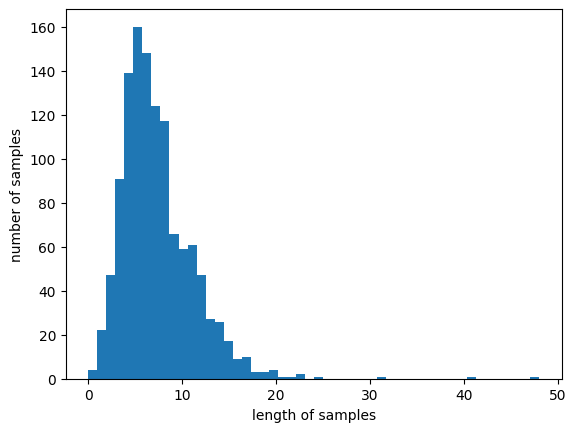

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [34]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 15
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 96.89597315436241


In [35]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [36]:
y_train = train['type']
y_test = test['type']

In [37]:
y_train.unique()

array([0, 1])

In [38]:
y_test.unique()

array([0, 1])

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [39]:
import tensorflow as tf
from keras.layers import Dense, Embedding, LSTM, Dropout, Input
from keras import optimizers
from keras.models import load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [41]:
from tensorflow.keras import backend as K

K.clear_session()

embedding_dim = 100
hidden_units = 64
num_classes = 1
input_length = max_len


# input ouput hidden 변수명 다 다르게 줘야함
x = Input(shape = (input_length))
h = Embedding(vocab_size, embedding_dim, input_length=input_length)(x)
h = LSTM(hidden_units)(h)
h = Dropout(0.5)(h)
h = Dense(512, activation='relu')(h)
y = Dense(num_classes,activation='sigmoid')(h)
model = Model(x,y)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=40,
                    callbacks=[es],
                    validation_data=(X_test,y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 100)           67500     
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 143533 (560.68 KB)
Trainable params: 143533 (56

In [ ]:
y_pred = np.where(model.predict(X_test).ravel() > 0.5, 1,0)

print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

### (2) 사전학습모델(Word2Vec)

* Pre-trained Word2Vec model
    * 이미 다운로드 받아서 제공되었습니다.
        * ko.bin, ko.tsv
    * 참고 사이트: https://github.com/Kyubyong/wordvectors
        * 모델 파일 다운로드 사이트: https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg
* 사전학습 모델을 로딩하고,
* train 데이터셋의 질문(Q)을 임베딩벡터로 만들어, 열(Column)로 추가합니다.

In [ ]:
!pip install gensim==3.8.3

#### 1) 모델 로딩
* 사전 학습된 모델을 로딩 : gensim.models.Word2Vec.load()
* 로딩 후 벡터 크기를 조회합시다. .vector_size

In [ ]:
import gensim
pre_wv_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/ddk/ko/ko.bin')